In [1]:
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
from PDBClean import pdbclean_io, pdbutils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Summary of PDB dataset 

## What is the goal of this notebook?


This notebook creates a summary of the basic features of a structure dataset. It takes as input the 'raw_bank' directory created during step 0. Users need to create a 'pdblist.txt' with the list of CIFs that will be included in the summary. Users also need to specify the directories where the CIFs are stored, and the directory where the created files will be stored. 

In the first step, a pandas dataframe is populated with the info read from the CIFs. The info in the dataframe is then written as a csv file. Additionally, two options are printed for the user asking if they prefer to see the shortened or full name version of the organisms. 
The shortened version only displays the first two words of the organism's name. 

(Example - [Full name: 'Leptospira interrogans serovar Icterohaemorrhagiae str. RGA']  --- [Short name: 'Leptospira interrogans'])

In a second step, we create an image with the plots summarizing the data in the dataframe. Four plots are included, a boxplot of the resolution of the structures, a histogram of the year in which the structures were published, a histogram of the methods used to solve the structures, and a histogram of the organism of origin of the molecule in the structure. The image with the four plots is saved as a pdf. 

## How to create the 'pdblist.txt'

This notebook uses 'pdblist.txt' which is derived from the files in the 'raw_bank'. To create the 'pdblist.txt' run this line within the terminal **in the 'raw_bank' directory**: 

>ls | grep cif > pdblist.txt




## Define functions

In [4]:
def make_pdb_df(read_directory_path, cif_list):
    """ 
        Extracts information from PDB cif files and creates a data frame with it.

        This function reads a list of CIF file names from 'pdblist.txt', extracts relevant information from 
        each CIF file, and compiles this information into a pandas DataFrame. The DataFrame includes details 
        such as PDB IDs, organism names, resolution, publication year, and experimental method. The function 
        also provides an option for users to choose between shortened or full names for the organisms.

        Parameters
        ----------
        read_directory_path : (str)
            The directory path where the CIF files are located and where the output CSV will be saved.
        cif_list : (str) 
            The name of the text file (e.g., 'pdblist.txt') containing the list of CIF file names.

        Returns
        ----------
        pandas.DataFrame  
            A DataFrame with the following columns
            - 'pdb_ids' : The 4 character PDB ID
            - 'orgalist' : Name of organism(s) in the PDB entry, formatted to the user's choice. 
            - 'resolution' : Resolution of structure in armstrong, 0 if not found.
            - 'year': Year of publication of PDB entry, None if not found .
            - 'method' : Experimental method used to determine structure listed in PDB entry, or an empty string if not found.  
    """

    pdb_ids = []
    orgalist = []
    resolution = []
    year = []
    method = []

    cif_name = open(read_directory_path + cif_list,'r')
    cif_name = cif_name.readlines()

    option = int(input('''Select choice:
    For shortened organism name type [1], for full organism type [2] '''))
    
    for item in range(0,len(cif_name)):
        pdb_id = cif_name[item].strip()
        pdb_id = pdb_id[0:4]
        pdb_ids.append(pdb_id)

        #pdbutils.download_pdb_from_id(oldfile, download_dir=read_dir)

        mmcif_dict = MMCIF2Dict(read_directory_path + pdb_id + ".cif")

        
        # Finding the organism
        org_keys = ['_entity_src_gen.pdbx_gene_src_scientific_name', '_entity_src_nat.pdbx_organism_scientific',
                      '_em_entity_assembly_naturalsource.organism']
        
        if option == 1:
            org_found = False
            for org in org_keys:
                if org in mmcif_dict:
                    unique_organism = list(set(mmcif_dict[org]))
                    formatted_organisms = []
                    for organism in unique_organism:
                        parts = organism.split()
                        if len(parts) > 2:
                            formatted_organisms.append(' '.join(parts[:2]).upper())
                        else:
                            formatted_organisms.append(' '.join(parts).upper())
                
                    orgalist.append('; '.join(formatted_organisms))
                    org_found = True
                    break

            if not org_found:
                orgalist.append('')
        
        if option == 2:
            org_found = False
            for org in org_keys:
                if org in mmcif_dict:
                    unique_organism = list(set(mmcif_dict[org]))
                    formatted_organisms = []
                    for organism in unique_organism:
                        parts = organism.split()
                        if len(parts) > 2:
                            formatted_organisms.append(' '.join(parts[:len(org)-1]).upper())
                        else:
                            formatted_organisms.append(' '.join(parts).upper())
                
                    orgalist.append('; '.join(formatted_organisms))
                    org_found = True
                    break
            
            if not org_found:
                orgalist.append('')
        

        
        #Finding the resolution
        res_keys = ['_refine.ls_d_res_high','_reflns.d_resolution_high', '_em_3d_reconstruction.resolution', '_reflns.d_resolution_high'
                     '_em_3d_reconstruction.resolution', '_reflns.d_resolution_high']
        for res in res_keys:
            if res in mmcif_dict and ((mmcif_dict[res][0] != '?') and (mmcif_dict[res][0] != '.')):
                  resolution.append(float(mmcif_dict[res][0]))
                  break
        else:
            resolution.append(0) 
            

        #Finding the year of publication
        pub_keys = ['_pdbx_database_status.recvd_initial_deposition_date', '_citation.year']
        pub_found = False
        for pub in pub_keys:
            if pub in mmcif_dict and ((mmcif_dict[pub][0][0:4] != '?') and (mmcif_dict[pub][0][0:4] != '.')):
                year.append(int(mmcif_dict[pub][0][0:4])) 
            pub_found = True
            break
       
        if not pub_found:
            year.append(None)  

        
        #Finding the method
        if '_exptl.method' in mmcif_dict:
            method.append(mmcif_dict['_exptl.method'][0])
        else:
            method.append('')
            
            
        print(pdb_ids[item], orgalist[item], resolution[item], year[item],method[item])
        ##print(pdb_ids[item],year[item])


    df = pd.DataFrame(list(zip(pdb_ids, orgalist,resolution,year,method)), 
                      columns = ['PDBid', 'Organism', 'Resolution (Å)','Year','Method'])
    

    
    return(df)
    
    #print(oldfile, orgalist)



In [5]:
def summary_plots_pdbs(df, output_directory, organism):
    """
     Generates and saves a collection of summary plots based on the provided DataFrame.

     Parameters
     ----------
     df : (pandas.DataFrame)
         Dataframe containing summarized information on the PDB dataset
     output_directory : (str)
         The directory path where the generated PDF file with the plots will be saved.
     organism : (str)
         The name of the organism used to name the output PDF file.

     Returns
     ----------
     None  
         This function saves the plots as a PDF file in the specified output directory and does not return any values.  
    """
    f = plt.figure(figsize = (32, 48))
    gs = f.add_gridspec(2, 2)
    fs = 40

    #PLOT RESOLUTION
    ax = f.add_subplot(gs[0, 0])
    #sns.boxplot(df['Resolution']).set(title="Resolution (Å)")
    #sns.boxplot(df[df['Resolution'].str.match('N/A')==False]['Resolution'])#.set(title="Resolution (Å)")
    sns.histplot(df['Resolution (Å)']) #.set(title="Resolution (Å)")
    plt.yticks(fontsize = fs)
    plt.xticks(fontsize = fs)
    #plt.title('Resolution (Å)', fontsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    
    
    #PLOT YEAR
    ax = f.add_subplot(gs[0, 1])
    sort_df = df.sort_values(by = "Year", ascending = True)
    plot = sns.histplot(sort_df['Year'])#.set(title="Year of Publication")
    xtick_loc = plot.get_xticks()
    xtick_labels = plot.get_xticklabels()

        # Set the x-axis ticks

    plt.setp(xtick_labels, rotation = 30, ha = "right")#, fontsize = 'x-small')
    plt.yticks(fontsize = fs)
    plt.xticks(fontsize = fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    
    #PLOT METHOD
    ax = f.add_subplot(gs[1, 0])
    method_counts = df['Method'].value_counts()

    # Only one unique method
    if len(method_counts) == 1:
        
        plot = sns.barplot(x = method_counts.index, y = method_counts.values, ax=ax)
        plt.xticks(rotation = 0, ha = 'center')
        # Font size customize
        plt.yticks(fontsize = fs)
        plt.xticks(fontsize = fs - 10)  # Adjusted font size for x-axis ticks
        ax.xaxis.label.set_size(fs)
        ax.yaxis.label.set_size(fs)
   
    # Multiple methods
    else:
        plot = sns.histplot(df['Method'])
        xtick_loc = plot.get_xticks()
        xtick_labels = plot.get_xticklabels()
        plt.setp(xtick_labels, rotation=30, ha="right")
        # Font size customize
        plt.yticks(fontsize = fs)
        plt.xticks(fontsize = fs - 20)
        ax.xaxis.label.set_size(fs)
        ax.yaxis.label.set_size(fs)

    #PLOT ORGANISM
    ax = f.add_subplot(gs[1, 1])
    sort_df = df['Organism'].value_counts(ascending = False).rename_axis('Organism').rename('count')
    plot = sns.barplot(x = sort_df.index, y = sort_df.values, order = sort_df.index)

        # Get x-axis tick locations and labels

    xtick_loc = plot.get_xticks()
    xtick_labels = plot.get_xticklabels()

        # Set the x-axis ticks

    plt.setp(xtick_labels, rotation = 30, ha = "right", fontsize = 'x-small')
    
    
    plt.subplots_adjust(bottom = 0.4)
    plt.yticks(fontsize = fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)


    #print("x-axis tick locations: " + str(xtick_loc))


    plt.savefig(output_directory + '/' + organism + "_summary_plots.pdf")


## Specify working directories

In [7]:
# TIM
PROJDIR = './TIM/'
read_directory_path = PROJDIR + '/raw_bank/'
cif_list = "./pdblist.txt"
output_directory = PROJDIR + '/SUMMARY/'
org_name = 'TIM'



In [8]:
pdbclean_io.check_project(projdir = PROJDIR, level = 'SUMMARY')

./TIM//SUMMARY already exists, with content:
['TIM_summary_plots.pdf', 'tim_summary_plots_oldversion.pdf', 'info.txt', 'tim_oldversion.csv', 'TIM.csv']


## Run functions

1. Populate dataframe with basic info of each structure: 'PDBid', 'Organism', 'Resolution','Year', 'Method' 
2. Create plots with summary of the basic info. 


In [10]:
# Populate dataframe
# Funcion prints items to screen
df = make_pdb_df(read_directory_path, cif_list)

Select choice:
    For shortened organism name type [1], for full organism type [2]  1


1ag1 TRYPANOSOMA BRUCEI 2.36 1997 X-RAY DIFFRACTION
1aw1 MORITELLA MARINA 2.7 1997 X-RAY DIFFRACTION
1aw2 MORITELLA MARINA 2.65 1997 X-RAY DIFFRACTION
1b9b THERMOTOGA MARITIMA 2.85 1999 X-RAY DIFFRACTION
1btm GEOBACILLUS STEAROTHERMOPHILUS 2.8 1995 X-RAY DIFFRACTION
1ci1 TRYPANOSOMA CRUZI 2.0 1999 X-RAY DIFFRACTION
1dkw TRYPANOSOMA BRUCEI 2.65 1999 X-RAY DIFFRACTION
1hg3 PYROCOCCUS WOESEI 2.7 2000 X-RAY DIFFRACTION
1hti HOMO SAPIENS 2.8 1994 X-RAY DIFFRACTION
1i45 SACCHAROMYCES CEREVISIAE 1.8 2001 X-RAY DIFFRACTION
1if2 LEISHMANIA MEXICANA 2.0 2001 X-RAY DIFFRACTION
1iig TRYPANOSOMA BRUCEI 2.6 2001 X-RAY DIFFRACTION
1iih TRYPANOSOMA BRUCEI 2.2 2001 X-RAY DIFFRACTION
1klg STAPHYLOCOCCUS AUREUS; HOMO SAPIENS 2.4 2001 X-RAY DIFFRACTION
1klu STAPHYLOCOCCUS AUREUS; HOMO SAPIENS 1.93 2001 X-RAY DIFFRACTION
1kv5 TRYPANOSOMA BRUCEI 1.65 2002 X-RAY DIFFRACTION
1lyx PLASMODIUM FALCIPARUM 1.9 2002 X-RAY DIFFRACTION
1lzo PLASMODIUM FALCIPARUM 2.8 2002 X-RAY DIFFRACTION
1m6j ENTAMOEBA HISTOLYTICA 1

In [11]:
# Write dataframe as CSV file 

df.to_csv(output_directory + org_name + '.csv')

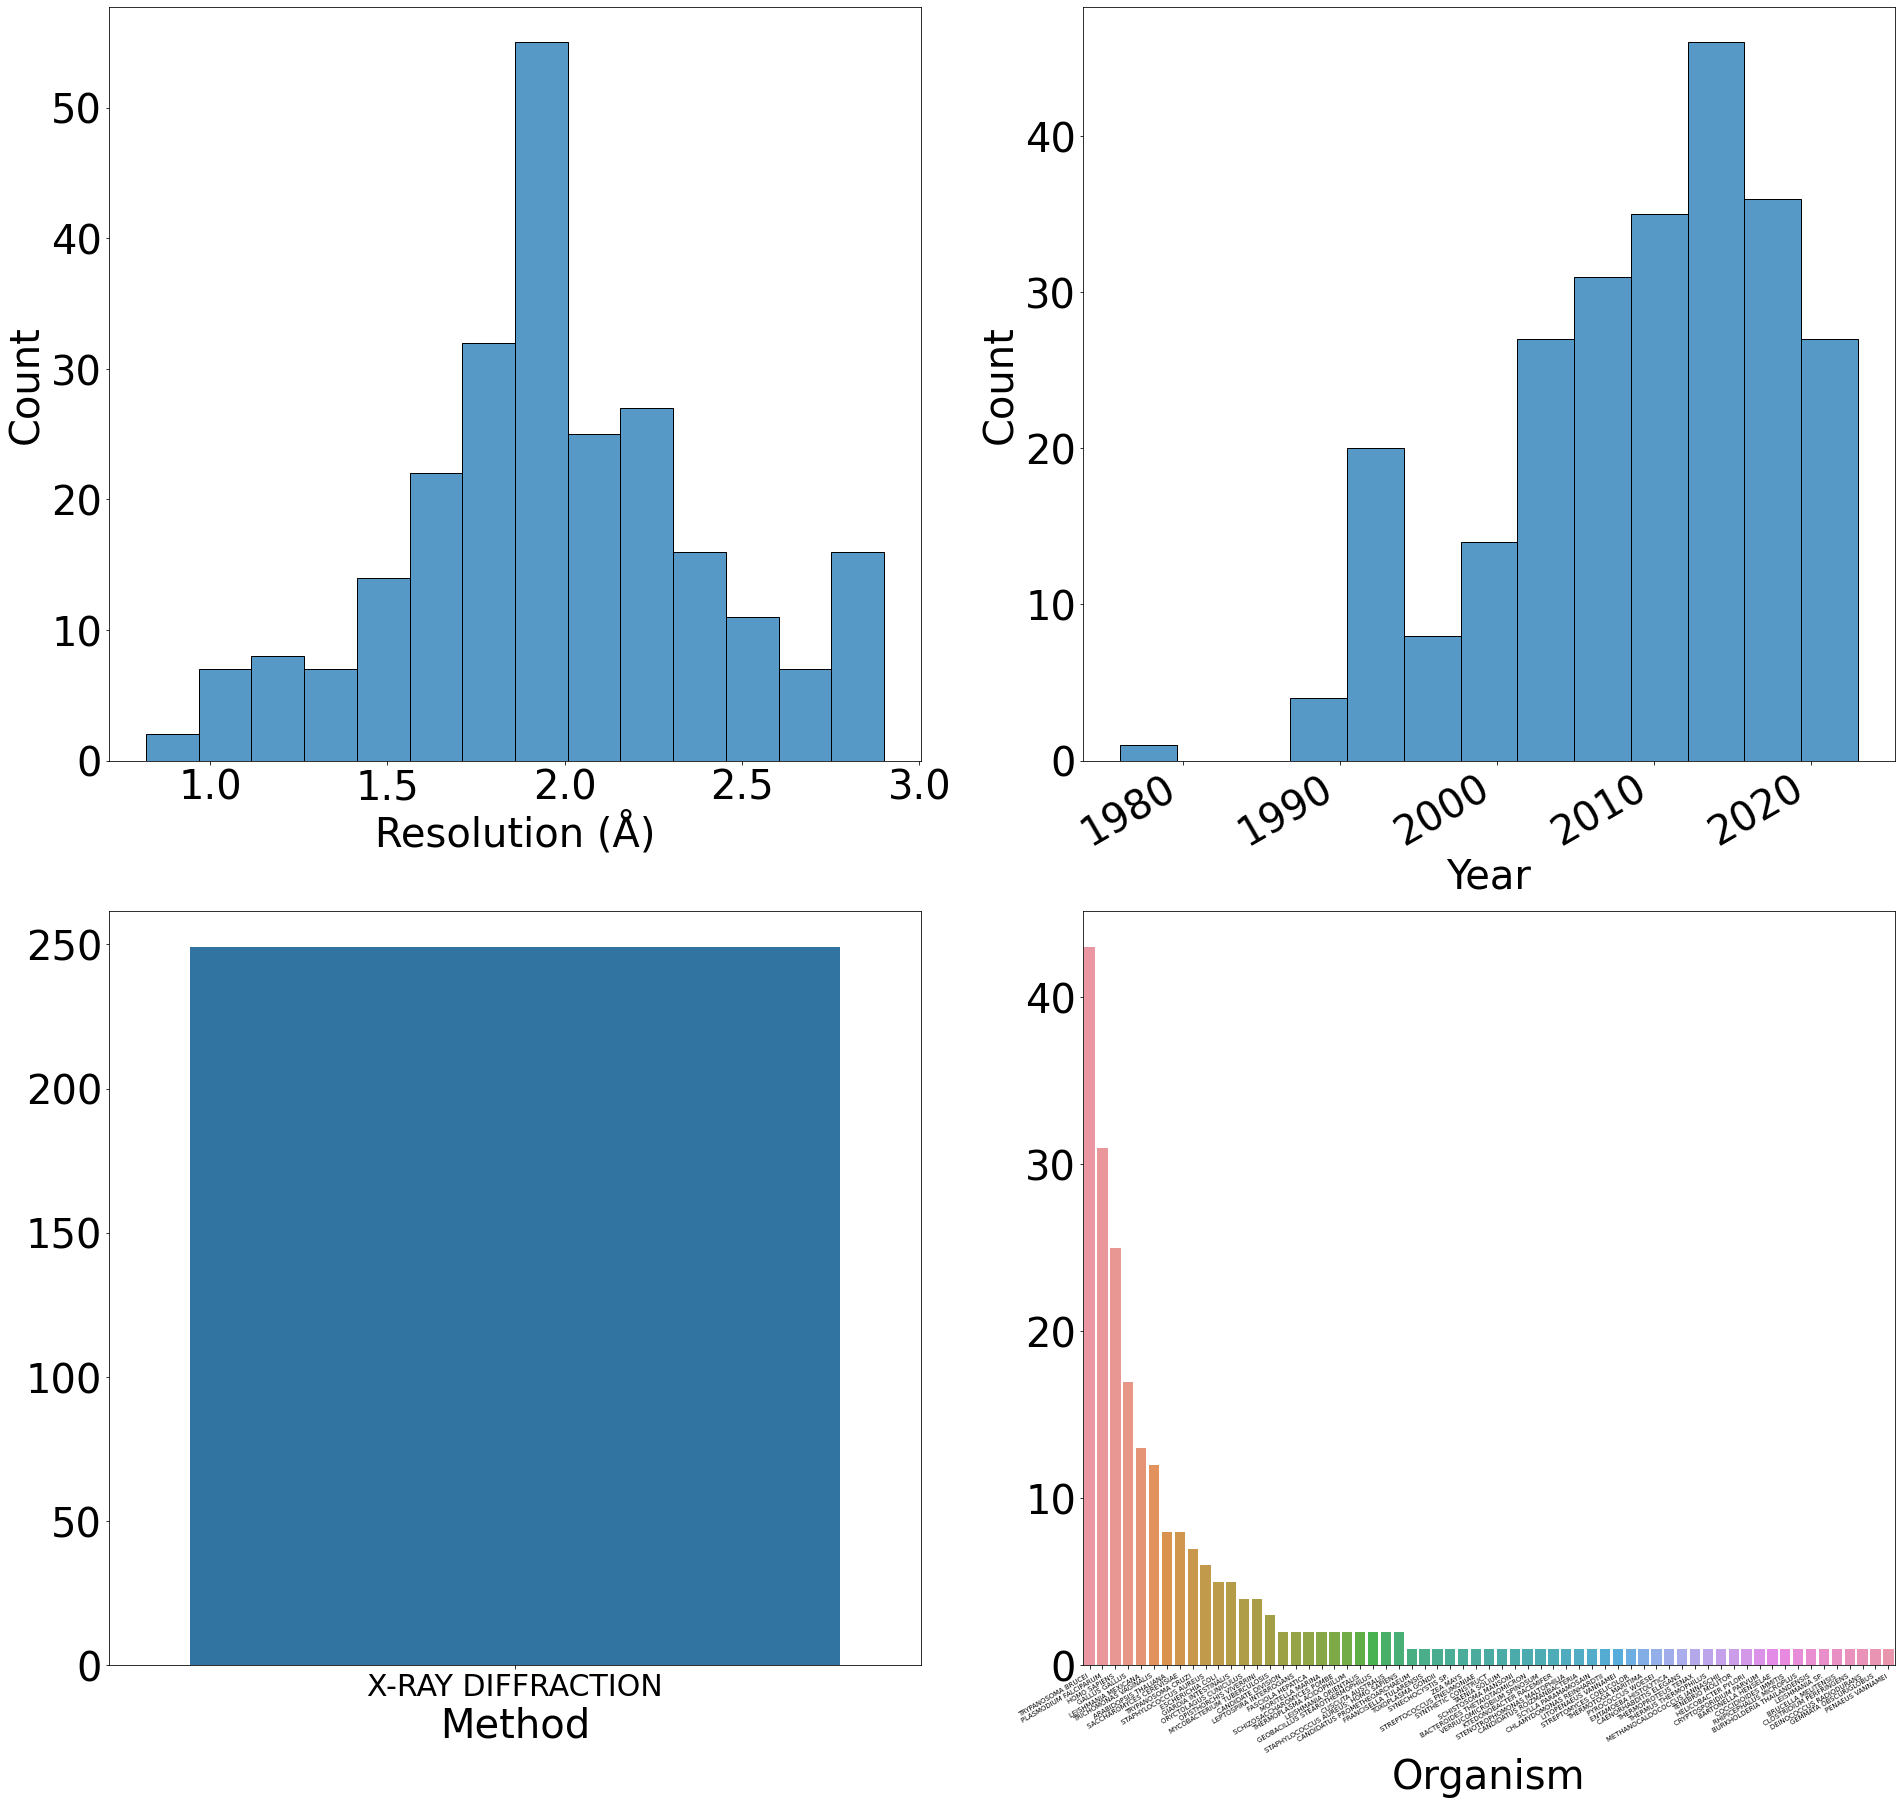

In [12]:
# Create images with the plots summarizing the info in the dataframe

summary_plots_pdbs(df, output_directory, org_name)